In [1]:
# to ignore the warnings 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# libraries for files preparation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil

# libraries for CNN models and plotting
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# install openpyxl to read excel files
!pip install openpyxl

In [11]:
import openpyxl
import pandas as pd


In [13]:
covid = pd.read_excel('covid-19_Radiography_Dataset/COVID.metadata.xlsx')
covid.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [14]:
normal = pd.read_excel('covid-19_Radiography_Dataset/Normal.metadata.xlsx')
normal.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [17]:
viral_pneumonia = pd.read_excel('covid-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')
viral_pneumonia.head()

,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


In [18]:
# Check the numbers of each cases
print("Covid cases: ", str(len(covid)))
print("Normal cases: ", str(len(normal)))
print("Viral Pneumonia cases: ", str(len(viral_pneumonia)))

Covid cases:  3616
Normal cases:  10192
Viral Pneumonia cases:  1345


In [20]:
# The least number of each class is 1345. Therefore, set the sample size to 1345 samples.
SAMPLE_SIZE = 1345

In [21]:
# add label for each case
covid['label'] = 0
normal['label'] = 1
viral_pneumonia['label'] = 2

In [22]:
# drop non-related columns
covid = covid[['FILE NAME', 'label']]
normal = normal[['FILE NAME', 'label']]
viral_pneumonia = viral_pneumonia[['FILE NAME', 'label']]

In [23]:
# covid dataframe
covid.head()

,FILE NAME,label
0,COVID-1,0
1,COVID-2,0
2,COVID-3,0
3,COVID-4,0
4,COVID-5,0


In [24]:
# sampling data for covid and normal cases
df_0 = covid.sample(SAMPLE_SIZE, random_state=26)
df_1 = normal.sample(SAMPLE_SIZE, random_state=26)

# concat dataframes
data = pd.concat([df_0, df_1, viral_pneumonia], axis=0).reset_index(drop=True)

# check numbers of each label
data['label'].value_counts()

0    1345
1    1345
2    1345
Name: label, dtype: int64

In [25]:
# shuffle data
data = shuffle(data)
data.head()

,FILE NAME,label
1807,NORMAL-7003,1
2511,NORMAL-3456,1
2323,NORMAL-8633,1
324,COVID-2068,0
1776,NORMAL-6310,1


In [26]:
df_train, df_val = train_test_split(data, test_size=0.20, random_state=26, stratify=data['label'])

print(df_train.shape)
print(df_val.shape)

(3228, 2)
(807, 2)


In [27]:
df_train['label'].value_counts()

1    1076
2    1076
0    1076
Name: label, dtype: int64

In [28]:
df_val['label'].value_counts()

1    269
2    269
0    269
Name: label, dtype: int64

In [30]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt

In [31]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


# create 2 folders inside 'base_dir':
# base_dir
  ## train_dir
     ### covid
     ### normal
     ### viral_pneumonia
  ## val_dir
     ### covid
     ### normal
     ### viral_pneumonia

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
train_covid = os.path.join(train_dir, 'covid')
os.mkdir(train_covid)
train_normal = os.path.join(train_dir, 'normal')
os.mkdir(train_normal)
train_viral_pneumonia = os.path.join(train_dir, 'viral pneumonia')
os.mkdir(train_viral_pneumonia)

# create new folders inside val_dir
val_covid = os.path.join(val_dir, 'covid')
os.mkdir(val_covid)
val_normal = os.path.join(val_dir, 'normal')
os.mkdir(val_normal)
val_viral_pneumonia = os.path.join(val_dir, 'viral pneumonia')
os.mkdir(val_viral_pneumonia)

In [32]:
# check the folders in train_dir
os.listdir('base_dir/train_dir')

['viral pneumonia', 'normal', 'covid']

# transforming images into folders

In [33]:
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])

In [35]:
# Copy images to train_dir folder
for image in train_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('covid-19_Radiography_Dataset/COVID', filename)
        
    if target == 1:
        label = 'normal'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        filename = filename.capitalize()
        src = os.path.join('covid-19_Radiography_Dataset/Normal', filename)
        
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join('covid-19_Radiography_Dataset/Viral Pneumonia', filename)
  
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to val_dir folder
for image in val_list:
    
    # add .png extension 
    filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == image, ['label']].values)
    
    # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        src = os.path.join('covid-19_Radiography_Dataset/COVID', filename)
        
    if target == 1:
        label = 'normal'
        filename = filename.capitalize()
        src = os.path.join('covid-19_Radiography_Dataset/Normal', filename)
        
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join('covid-19_Radiography_Dataset/Viral Pneumonia', filename)
  
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [36]:
# check the number of train images in each folder
print(len(os.listdir('base_dir/train_dir/covid')))
print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/viral pneumonia')))

1076
1076
1076


In [37]:
# check the number of validation images in each folder
print(len(os.listdir('base_dir/val_dir/covid')))
print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/viral pneumonia')))

269
269
269


# image classification

In [39]:
BATCH_SIZE = 32
IMG_SIZE = (256  , 256)
train_directory = "base_dir/train_dir"
val_directory = "base_dir/val_dir"
                                 

## Generate Train/Val Dataset

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_directory,
        target_size=IMG_SIZE,
        color_mode='grayscale',
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 3228 images belonging to 3 classes.
Found 807 images belonging to 3 classes.


In [41]:
# check classes in train_generator
train_generator.class_indices

{'covid': 0, 'normal': 1, 'viral pneumonia': 2}

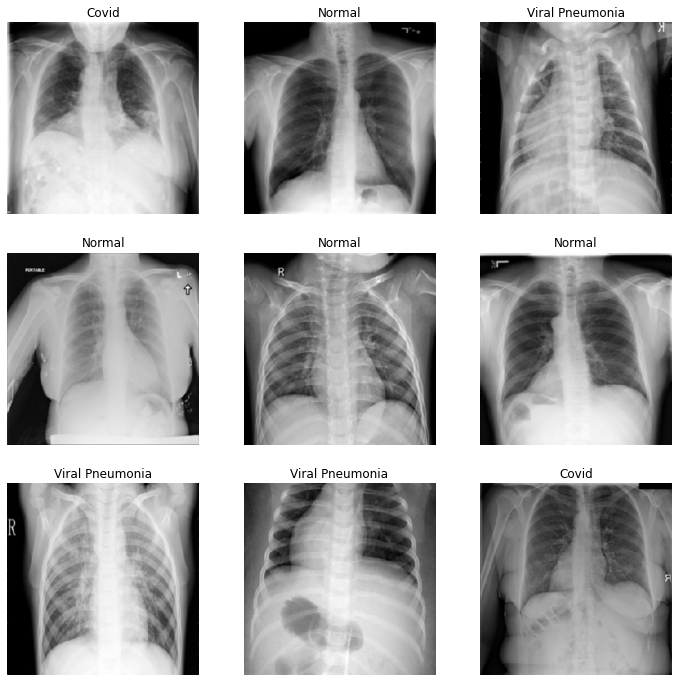

In [42]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = train_generator.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Normal', 2:'Viral Pneumonia'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

# Model Fitting
## The model architecture is based on VGG-16 model, including 3x3 filter for convolutions layer and 2x2 filter for pooling layers, doubling the number of filters and three fully-connected layers.

In [43]:
def covid_model1(IMG_SIZE):
    input_shape = IMG_SIZE + (1, )
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=input_shape),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(32, (3, 3), padding='same', activation="relu"),
        MaxPooling2D(pool_size = (2, 2)), 
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(256, (3, 3), padding='same',activation="relu"),
        MaxPooling2D(pool_size = (2, 2)),
        Flatten(),
       
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=3, activation='softmax')
    ])
    return model

In [44]:
# recheck the image size
IMG_SIZE

(256, 256)

In [45]:
model1 = covid_model1(IMG_SIZE)

Metal device set to: Apple M1 Pro


2022-03-14 10:27:57.416171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 10:27:57.417014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [46]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [47]:
base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [49]:
initial_epochs = 15
history = model1.fit(train_generator, epochs=initial_epochs, 
                     validation_data = validation_generator, callbacks=[early_stopping])

Epoch 1/15


2022-03-14 10:29:02.999827: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 10:29:03.300276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.6211

2022-03-14 10:29:19.707448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - 19s 139ms/step - loss: 0.7583 - accuracy: 0.6211 - val_loss: 0.5754 - val_accuracy: 0.7646
Epoch 2/15
101/101 [==============================] - 13s 125ms/step - loss: 0.5634 - accuracy: 0.7556 - val_loss: 0.5339 - val_accuracy: 0.7745
Epoch 3/15
101/101 [==============================] - 13s 125ms/step - loss: 0.4798 - accuracy: 0.7934 - val_loss: 0.4807 - val_accuracy: 0.7906
Epoch 4/15
101/101 [==============================] - 13s 132ms/step - loss: 0.3976 - accuracy: 0.8364 - val_loss: 0.4179 - val_accuracy: 0.8166
Epoch 5/15
101/101 [==============================] - 13s 123ms/step - loss: 0.3449 - accuracy: 0.8575 - val_loss: 0.3730 - val_accuracy: 0.8401
Epoch 6/15
101/101 [==============================] - 13s 130ms/step - loss: 0.3189 - accuracy: 0.8656 - val_loss: 0.2886 - val_accuracy: 0.8823
Epoch 7/15
101/101 [==============================] - 13s 125ms/step - loss: 0.2790 - accuracy: 0.8897 - val_loss: 0.2809 - val_accuracy: 0.8

In [50]:
# Evaluate the model by getting its final loss and accuracy
model1.evaluate(validation_generator)

26/26 [==============================] - 1s 51ms/step - loss: 0.2371 - accuracy: 0.9095


[0.2371184527873993, 0.9095415472984314]

In [51]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

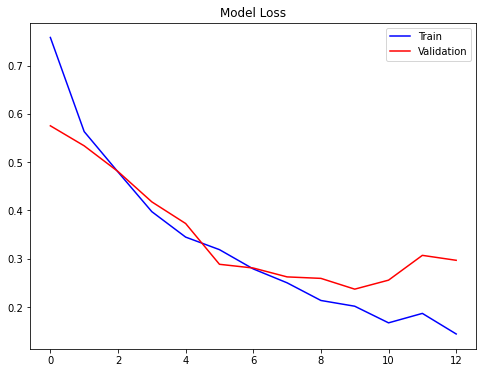

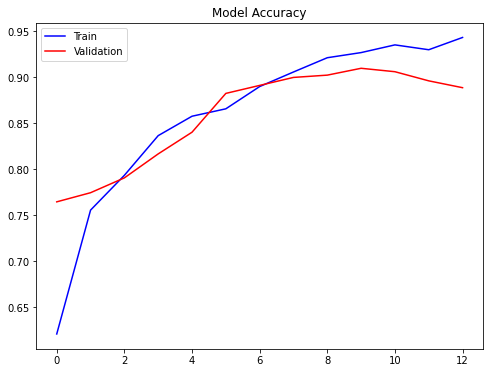

In [52]:
plot_loss_acc(history)

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [54]:
# predict classes of validation dataset
val_predict = model1.predict(validation_generator)

2022-03-14 10:34:03.241270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [55]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [56]:
labels = ['Covid', 'Normal', 'Viral Pneumonia']
report = classification_report(validation_generator.classes, predict_class, target_names=labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.85      0.93      0.89       269
         Normal       0.92      0.84      0.88       269
Viral Pneumonia       0.97      0.96      0.96       269

       accuracy                           0.91       807
      macro avg       0.91      0.91      0.91       807
   weighted avg       0.91      0.91      0.91       807



In [57]:
cm = confusion_matrix(validation_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL','VIRAL PNEUMONIA'], 
                     columns = ['COVID','NORMAL','VIRAL PNEUMONIA'])

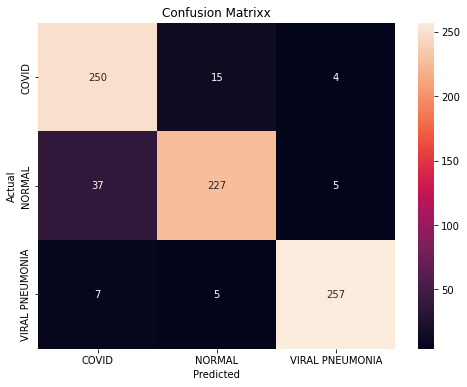

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()